<a href="https://colab.research.google.com/github/J0han-ai/fast.ai/blob/main/Albumentations_2_likeD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#для kaggle 
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.6 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [ ]:
import pandas as pd
%matplotlib inline

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

In [ ]:
from fastai import *
from fastai.vision.all import *


In [ ]:
#!pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ywy1hpi6
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ywy1hpi6


In [ ]:
#!Albumentations.Мегакрутая вещь!
# Начало albumentations


import albumentations as Alb
import cv2


class AlbTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
def get_augs(): return  Alb.Compose([
    Alb.ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
    Alb.GaussNoise(p=0.1),
    Alb.GaussianBlur(blur_limit=3, p=0.05),
    Alb.HorizontalFlip(),

    Alb.RandomBrightnessContrast(),
    Alb.OneOf([Alb.RandomBrightnessContrast(), Alb.FancyPCA(), Alb.HueSaturationValue()], p=0.7),
    #Alb.PadIfNeeded(),Сильно меняет изображение, попробовать отдельно c ним
    Alb.ToGray(p=0.2), 
    Alb.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
                                     ])  
  
    
#Надо посмотреть, что еще можно подобрать, исходя из условий задачи.
#статьи по подбору аугментации в мед процессинге
#https://arxiv.org/pdf/2010.11695.pdf
#https://arxiv.org/pdf/2003.04696v5.pdf




In [ ]:
item_tfms = [Resize(224), AlbTransform(get_augs())]
batch_tfms = Normalize.from_stats(*imagenet_stats) 

# Конец albumentations

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1766: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_path='/content/drive/MyDrive/train_xray'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip())





In [ ]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [ ]:
dls = ImageDataLoaders.from_df(train_df,
                               path=train_path, 
                               suff='-c.bone.jpg',
                               item_tfms=item_tfms,
                               batch_tfms=batch_tfms, 
                               shuffle=True, 
                               bs=64, 
                               valid_pct=0.2,
                               label_delim=' ',# !важно! - предупреждаем нейросеть,что у нас есть некоторая multi-label problem
                                               # без этого будет вываливаться ошибка при обучении cnn
                               num_workers = 0, #Чтобы не переполнялась память при обучении
                               )

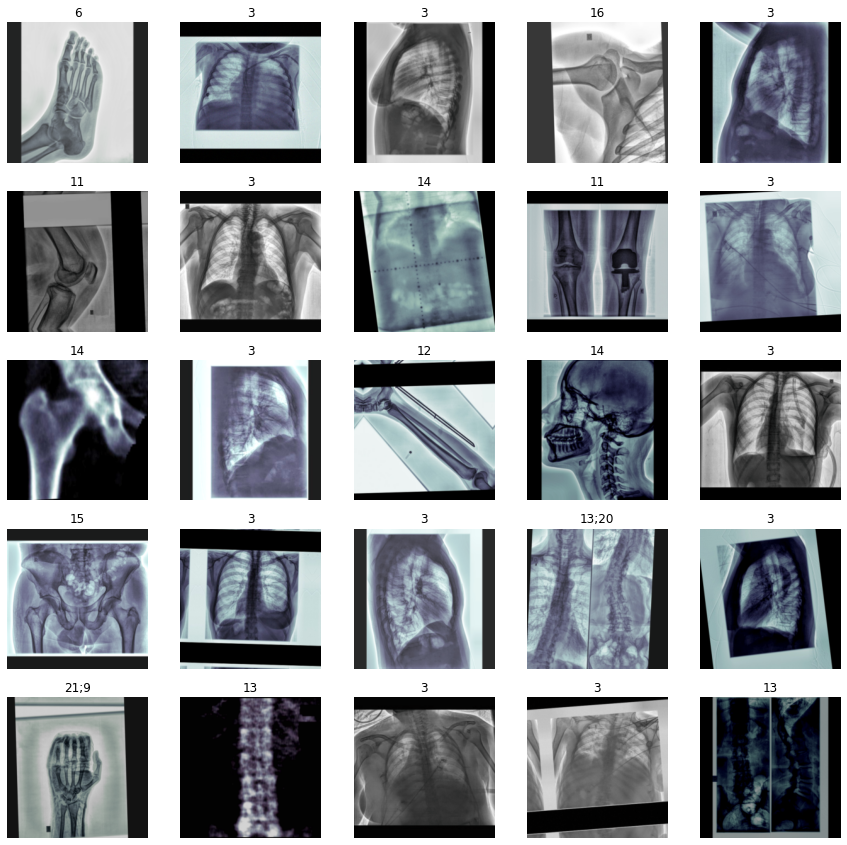

In [ ]:
dls.train.show_batch(max_n=25)


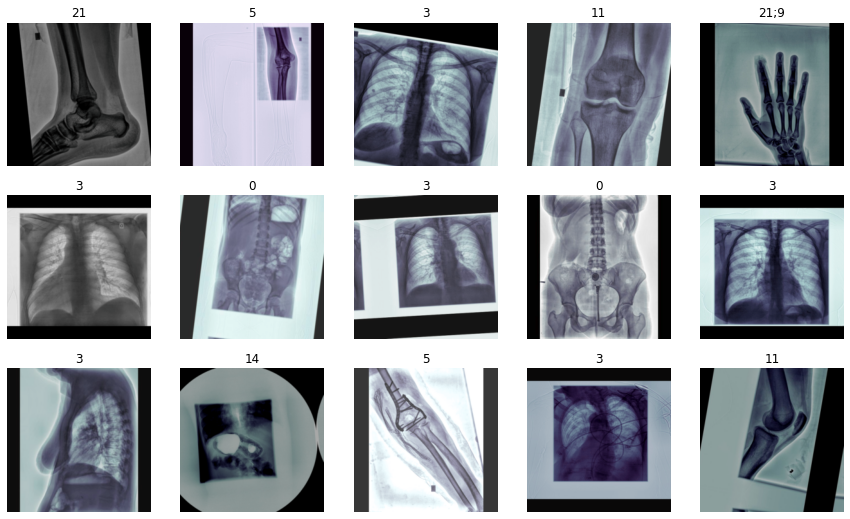

In [ ]:
dls.valid.show_batch(max_n=15)

In [ ]:
#Чтобы корректно считалась метрика F1Score, взял с public kernel этого Kaggle-соревнования.
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_weighted = F1ScoreMulti(thresh=0.5, average='weighted')



In [ ]:
learn = vision_learner(dls, resnet50, 
                    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples, f1_micro, f1_weighted]
                      )

CPU times: user 3min 34s, sys: 30 s, total: 4min 4s
Wall time: 23min 10s


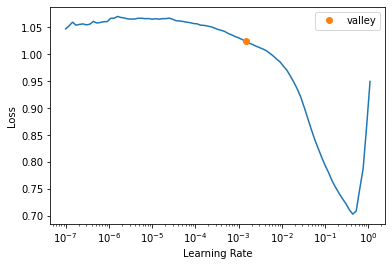

In [ ]:
%%time
lr = learn.lr_find() 

In [ ]:
%%time
learn.fine_tune(90,1e-3
                #lr[0]
                )

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.995120,0.717442,0.584228,0.158205,0.190229,0.184481,0.446076,01:00


epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.891302,0.701675,0.582526,0.159624,0.191831,0.183867,0.461040,01:02
1,0.879904,0.673800,0.611344,0.168446,0.202544,0.195281,0.468594,01:17
2,0.866890,0.656879,0.620775,0.171544,0.205392,0.197839,0.475253,01:03
3,0.849894,0.654449,0.618287,0.175050,0.208552,0.197687,0.476943,01:04
4,0.834581,0.624527,0.652738,0.186536,0.227839,0.215912,0.492602,01:07
5,0.819500,0.617246,0.659156,0.184405,0.230999,0.215320,0.498248,01:06
6,0.804892,0.604645,0.676841,0.195771,0.239333,0.227372,0.508173,01:04
7,0.787010,0.578003,0.707493,0.204075,0.264531,0.242280,0.515055,01:04
8,0.768332,0.560341,0.729369,0.217438,0.285444,0.258967,0.521171,01:04
9,0.744909,0.546005,0.750459,0.229147,0.306255,0.274286,0.545312,01:04


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-pack

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.891302,0.701675,0.582526,0.159624,0.191831,0.183867,0.461040,01:02
1,0.879904,0.673800,0.611344,0.168446,0.202544,0.195281,0.468594,01:17
2,0.866890,0.656879,0.620775,0.171544,0.205392,0.197839,0.475253,01:03
3,0.849894,0.654449,0.618287,0.175050,0.208552,0.197687,0.476943,01:04
4,0.834581,0.624527,0.652738,0.186536,0.227839,0.215912,0.492602,01:07
5,0.819500,0.617246,0.659156,0.184405,0.230999,0.215320,0.498248,01:06
6,0.804892,0.604645,0.676841,0.195771,0.239333,0.227372,0.508173,01:04
7,0.787010,0.578003,0.707493,0.204075,0.264531,0.242280,0.515055,01:04
8,0.768332,0.560341,0.729369,0.217438,0.285444,0.258967,0.521171,01:04
9,0.744909,0.546005,0.750459,0.229147,0.306255,0.274286,0.545312,01:04


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-pack

KeyboardInterrupt: ignored

In [ ]:
#посмотрим топ-ошибок.Вернее не посмотрим, потому что -вероятно из за деления на ноль при подсчете F1score - некоторые классы не предсказывает.
#Надо пробовать делать valid_pct=0 и указывать для валидации данные из другой папки, которая "тест".
#А все содержимое папки трейн загонять на обучение полностью.Или делать больше данных через аугментацию.
#либо, как тут написано, задавать  параметр zero_division  в sklearn.metrics.classification_report
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_top_losses(15, figsize=(15, 10))

In [ ]:
learn.export()
learn.save('Albumentations#2_DeepF_model') 

Path('/content/drive/MyDrive/train_xray/models/Albumentations#2_DeepF_model.pth')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


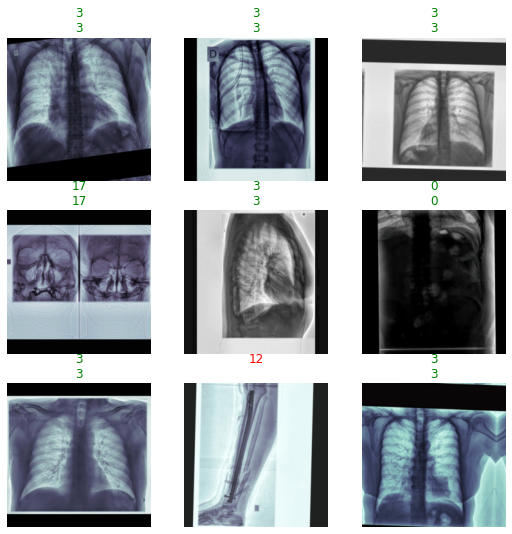

In [ ]:
learn.show_results()

In [ ]:
#Predictions to csv

In [ ]:
#!zip -r test.zip /content/drive/MyDrive/xr/xray/test

In [ ]:
#!unzip -j /content/test.zip -d /content/drive/MyDrive/test

In [ ]:
test_df = pd.read_csv ('/content/drive/MyDrive/xr/xray/sample_submission.csv')
# pd.read_csv ('/content/submit.csv')
#pd.read_csv ('/content/drive/MyDrive/xr/xray/sample_submission.csv')
test_path= ('/content/drive/MyDrive/test')

In [ ]:
test_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746555980174715994054,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
739,1.2.826.0.1.3680043.8.498.99120415799121180043999929775380253296,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
740,1.2.826.0.1.3680043.8.498.99132008951330408682785705454375383148,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21
741,1.2.826.0.1.3680043.8.498.99611256581875030709909119881605604054,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21


In [ ]:
tdls = ImageDataLoaders.from_df(test_df, path=test_path, suff='-c.bone.jpg',
   item_tfms=item_tfms, batch_tfms=batch_tfms, shuffle=False)
tst_dl = tdls.test_dl(test_df) 

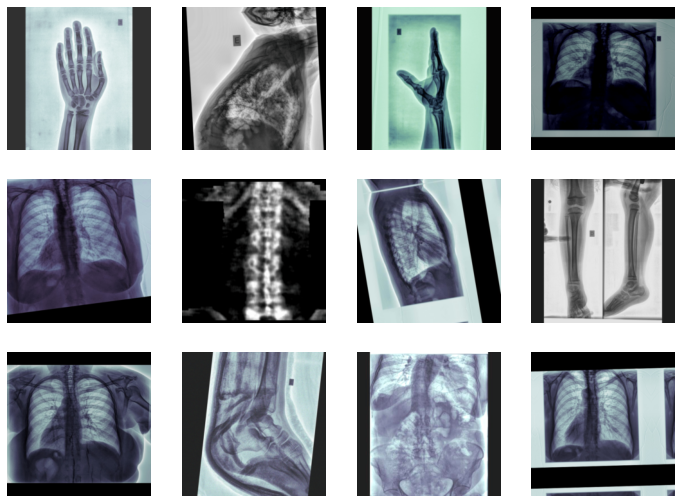

In [ ]:
tst_dl.show_batch(max_n=12)

In [ ]:
%%time
preds = learn.tta(dl=tst_dl, n=64, use_max=False)
#preds = learn.get_preds(dl=tst_dl, n=64, use_max=False)
#preds = learn.get_preds(dl=tst_dl)
#preds = learn.get_preds

CPU times: user 1min 52s, sys: 8.11 s, total: 2min
Wall time: 18min 24s


In [ ]:
#!pip uninstall nbdev.......,,..,
#!pip install nbdev

In [ ]:
predss = learn.dls.vocab[np.argmax(preds[0], axis=1)]

In [ ]:
test_df['Target'] = predss

In [ ]:
submission_df = test_df[['SOPInstanceUID', 'Target']]

In [ ]:
submission_df.to_csv(f'Gooodboy.csv', header=True, index=False)

In [ ]:
submission_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10001001190452685542754353271306894106,5
1,1.2.826.0.1.3680043.8.498.10022667601042710442884728915610557590,5
2,1.2.826.0.1.3680043.8.498.10024395388921105474336784272390605225,7
3,1.2.826.0.1.3680043.8.498.10026689165626095651568657562992631805,11
4,1.2.826.0.1.3680043.8.498.10035936364561920980924160549027696414,7
...,...,...
738,1.2.826.0.1.3680043.8.498.98950979295424909746555980174715994054,11
739,1.2.826.0.1.3680043.8.498.99120415799121180043999929775380253296,11
740,1.2.826.0.1.3680043.8.498.99132008951330408682785705454375383148,7
741,1.2.826.0.1.3680043.8.498.99611256581875030709909119881605604054,0


In [ ]:
test_df.Target.value_counts()

11    262
7     227
5     111
17     87
12     33
9       7
21      6
19      4
0       3
13      3
Name: Target, dtype: int64

AttributeError: 'dict' object has no attribute ..

'When you bring your learner back in make sure to re-define any functions your model wants to use along with it'
